# Статистический анализ: исследование сервиса аренды самокатов

В моем распоряжении данные сервиса аренды самокатов. Пользователи сервиса делятся на два типа: с подпиской и без. Пользователи без подписки платят 50р. за старт поездки и 8р. за минуту пользования. Пользователи с подпиской платят 199р. абонентской платы в месяц и 6р. за минуту поездки.

**Цели исследования:**
1. Изучить пользователей сервиса, продолжительность их поездок
2. Оценить выручку, которую приносят пользователи с подпиской и без нее
3. Проверить гипотезы о различиях пользователей

**Ход исследования**

Данные я получу из трех файлов
- `users_go.csv` данные о пользователях
- `rides_go.csv` данные о их поездках
- `subscriptions_go.csv` данные об условиях подписки

Для начала оценю данные, приведу их к необходимому формату, если потребуется, проверю данные на количество пропусков, дубликатов, обработаю их. Затем проведу исследовательский анализ данных, подсчитаю выручку и проверю поставленные гипотезы.

Для выполнения проекта необходимо несколько библиотек, загружу их:

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
from math import factorial
import matplotlib.pyplot as plt

## Загрузка и обзор данных

In [2]:
users = pd.read_csv(r'C:\Users\HOME\Desktop\Practicum\datasets\scooter_rent\users_go.csv')
rides = pd.read_csv(r'C:\Users\HOME\Desktop\Practicum\datasets\scooter_rent\rides_go.csv')
subs = pd.read_csv(r'C:\Users\HOME\Desktop\Practicum\datasets\scooter_rent\subscriptions_go.csv')

### Изучу данные о пользователях в `users`

In [3]:
print(users.head())
users.info()

   user_id        name  age            city subscription_type
0        1        Кира   22          Тюмень             ultra
1        2   Станислав   31            Омск             ultra
2        3     Алексей   20          Москва             ultra
3        4  Константин   26  Ростов-на-Дону             ultra
4        5       Адель   28            Омск             ultra
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [4]:
users.city.unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

Отлично, в данных нет пропусков, и видно, что сервис представлен сразу в 6 разных городах, есть западные, восточные и южные города. Будет интересно узнать как отличаются данные в зависимости от города.

### Изучу данные о поездках в `rides`

In [5]:
print(rides.head())
rides.info()

   user_id     distance   duration        date
0        1  4409.919140  25.599769  2021-01-01
1        1  2617.592153  15.816871  2021-01-18
2        1   754.159807   6.232113  2021-04-20
3        1  2694.783254  18.511000  2021-08-11
4        1  4028.687306  26.265803  2021-08-28
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Тут тоже нет пропусков, только дату необходимо привести к подобающему формату.

In [6]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

### Изучу данные о подписках в `subs`

In [7]:
subs

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Как и говорилось в введении, у пользователей есть два варианта пользоваться сервисом - с подпиской и ежемесячным платежом, но с пониженной стоимостью минут. Или без подписки, но с платой за старт и более высокой ценой за минуту поездки.

## Предобработка данных

### Удаление дубликатов

Проверю все файлы на наличие дубликатов

In [8]:
for i in [users, rides, subs]:
    print(i.duplicated().sum())

31
0
0


Дубликаты есть только в файле `users`. Удалю их:

In [9]:
users.drop_duplicates(inplace=True)

### Добавление столбца с номером месяца

Все данные в датафрейме собраны за 2021 год. Добавлю для них обозначение месяца

In [10]:
rides['month'] = rides['date'].dt.month

## Исследовательский анализ данных

### Частота встречаемости городов в данных

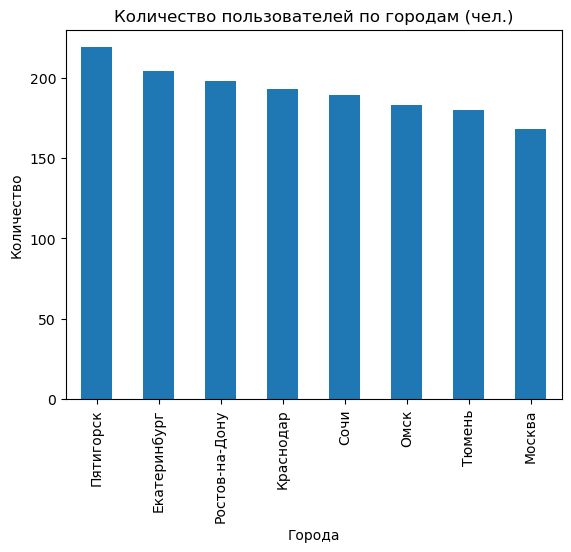

In [11]:
(users
 .pivot_table(index='city', values='user_id', aggfunc='count')
 .sort_values(by='user_id', ascending=False)
 .plot(kind='bar', title='Количество пользователей по городам (чел.)',
       legend=False))
plt.xlabel('Города')
plt.ylabel('Количество');



Распределение пользователей по городам на удивление равномерное. Так, количество пользователей не зависит от численности населения. Например, больше всего пользователей в Пятигорске (всего 219 пользователей), хотя это город с маленьким населением в 145 тыс. человек

### Доли пользователей по типу подписки

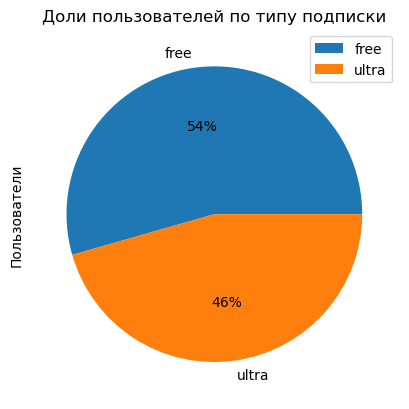

In [12]:
(users
 .pivot_table(index='subscription_type', values='user_id', aggfunc='count')
 .plot(kind='pie', y='user_id', autopct='%1.0f%%', title='Доли пользователей по типу подписки'))
plt.ylabel('Пользователи');

Большая часть пользователей арендует самокаты без подписки. Хотя доля тех, кто пользуется подпиской, тоже велика.

### Возраст пользователей

Медианный возраст пользователей сервиса: 25.0


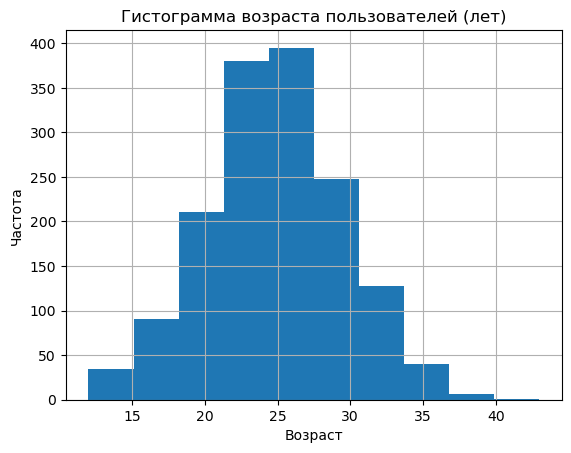

In [13]:
print('Медианный возраст пользователей сервиса:', users.age.median())
users.plot(kind='hist', y='age', grid=True, title='Гистограмма возраста пользователей (лет)', legend=False)
plt.xlabel('Возраст')
plt.ylabel('Частота');

Распределение по возрасту - нормальное. И больше всего пользователей в возрастном диапозоне от 20 до 30.
<br> Посмотрим, меняется ли медианный возраст пользователей в зависимости от города.

In [89]:
pd.DataFrame(users.pivot_table(index='city', values='age', aggfunc='median')
            ).style.background_gradient('Greens')

,age
city,
Екатеринбург,25
Краснодар,25
Москва,25
Омск,26
Пятигорск,25
Ростов-на-Дону,25
Сочи,25
Тюмень,25


Во всех представленных городах медианный возраст пользователей составляет 25 лет. За исключением Омска, в котором пользователи на год старше. Но такая разница совсем не существенна.

### Расстояние, которое преодолевают пользователи

Медианное расстояние, которое преодолевают пользователи: 3134 метров


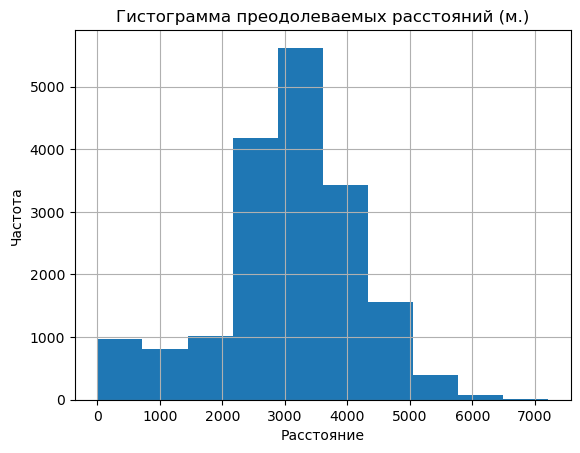

In [15]:
print('Медианное расстояние, которое преодолевают пользователи:', round(rides.distance.median()), 'метров')
rides['distance'].plot(kind='hist', grid=True, title='Гистограмма преодолеваемых расстояний (м.)')
plt.xlabel('Расстояние')
plt.ylabel('Частота');

In [16]:
rides.distance.describe().apply('{0:.2f}'.format)

count    18068.00
mean      3070.66
std       1116.83
min          0.86
25%       2543.23
50%       3133.61
75%       3776.22
max       7211.01
Name: distance, dtype: object

И тут распределение близится к нормальному, но с выраженным пиком между 2500 и 3700 метров. В этот диапозон укладывается половина всех поездок!

### Продолжительность поездки

По логике время поездки должно коррелировать с расстоянием. Проверю это:

In [17]:
print('Корреляция между временем и расстоянием поездки:', round(rides.distance.corr(rides.duration), 2))

Корреляция между временем и расстоянием поездки: 0.54


Корреляция действительно наблюдается. Рассмотрю распределение продолжительности поездки на гистограмме

count    18068.00
mean        17.81
std          6.09
min          0.50
25%         13.60
50%         17.68
75%         21.72
max         40.82
Name: duration, dtype: object

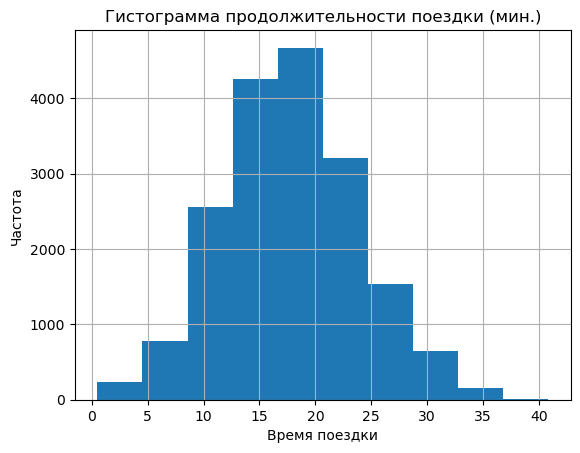

In [18]:
rides['duration'].plot(kind='hist', grid=True, title='Гистограмма продолжительности поездки (мин.)')
plt.xlabel('Время поездки')
plt.ylabel('Частота')
rides.duration.describe().apply('{0:.2f}'.format)

Опять-таки, продолжительность поездки, ожидаемо, напоминает нормальное распределение, <br>где половина поездок умещается в диапозон от 13 до 21 минуты.

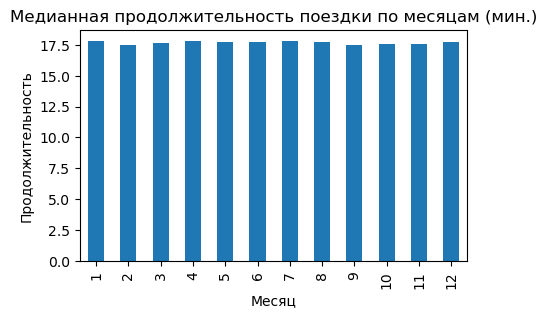

In [19]:
(rides
 .groupby('month')['duration'].median()
 .plot(kind='bar', figsize=(5,3), title='Медианная продолжительность поездки по месяцам (мин.)'))
plt.xlabel('Месяц')
plt.ylabel('Продолжительность');

На удивление, во все сезоны пользователи преодолевают одинаковые расстояния.

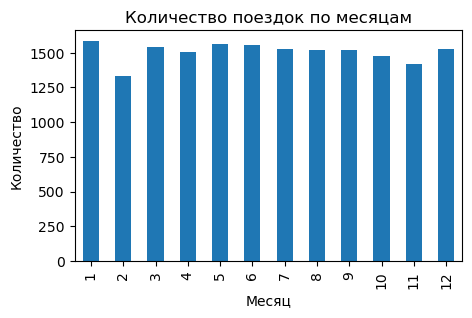

In [20]:
(rides.groupby('month')['user_id'].count()
 .plot(kind='bar', figsize=(5,3), title='Количество поездок по месяцам'))
plt.xlabel('Месяц')
plt.ylabel('Количество');

И количество поездок сильно не разнится.

## Объединение данных

### Объединю в один датафрейм все три набора данных

Набор данных, в котором будут объединена информация о пользователях, поездках и условиях подписки назову `full_data` 

In [21]:
#Сначала присоединю к поездкам данные о пользователях по user_id
full_data = rides.merge(users, on='user_id', how='left')

#Затем присоединю к готовому набору информацию об условиях подписки
full_data = full_data.merge(subs, on='subscription_type')

Посмотрим, как теперь выглядит `full_data`

In [22]:
full_data.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


Так как новый датафрейм был собран на основе `rides`, проверю, все ли его строки вошли в `full_data`

In [23]:
print('Количество упущенных строк:', len(rides) - len(full_data))

Количество упущенных строк: 0


### Посмотрю, зависит ли продолжительность поездки и дистанция от города

In [80]:
print('\033[1m'+'Медианное расстояние поездки по городам')
pd.DataFrame(full_data.pivot_table(index='city',
                                   values='distance',
                                   aggfunc='median')).style.background_gradient('GnBu').format('{0:.2f}')

Медианное расстояние поездки по городам


,distance
city,
Екатеринбург,3182.11
Краснодар,3136.90
Москва,3160.41
Омск,3110.42
Пятигорск,3157.96
Ростов-на-Дону,3089.69
Сочи,3103.13
Тюмень,3132.91


In [82]:
print('\033[1m'+'Медианная длительность поездки по городам')
pd.DataFrame(full_data.pivot_table(index='city',
                                   values='duration',
                                   aggfunc='median')).style.background_gradient('GnBu').format('{0:.2f}')

Медианная длительность поездки по городам


,duration
city,
Екатеринбург,17.56
Краснодар,17.61
Москва,18.15
Омск,17.66
Пятигорск,17.89
Ростов-на-Дону,17.48
Сочи,17.36
Тюмень,17.76


Значения снова не сильно отличаются друг от друга. Однако заметно, что в Москве, самом крупном городе из представленных, длительность поездки и расстояние - выше других, что соответствует логике.
<br> Любопытно также, что хоть в Екатеринбурге преодолевают самые большие расстояния, но длительность поездки одна из самых низких. Это может быть связано как с дорожной инфраструктурой (загруженностью, кол-вом светофоров), так и со скоростью поездки или с другими факторами. Но так как данных, чтобы проверить такие гипотезы нет - пропущу этот любопытный момент.

### Отдельно выделю данные о пользователях по их подпискам 

Датафреймы, в котором будут собраны данные о пользователях по типу подписок назову соответственно подпискам: `ultra_sub` и `free_sub`

In [26]:
ultra_sub = full_data.query('subscription_type == "ultra"')
free_sub = full_data.query('subscription_type == "free"')

**Расстояние поездок в зависимости от типа подписки**

По расстояниям построю гистограммы для двух типов подписок.

<Axes: title={'center': 'Гистограмма расстояния поездки у подписок ultra (м.)'}, ylabel='Frequency'>

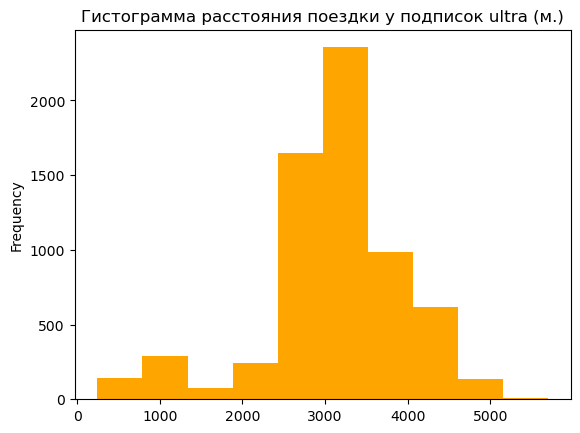

In [27]:
ultra_sub['distance'].plot(kind='hist', color='orange', title='Гистограмма расстояния поездки у подписок ultra (м.)');

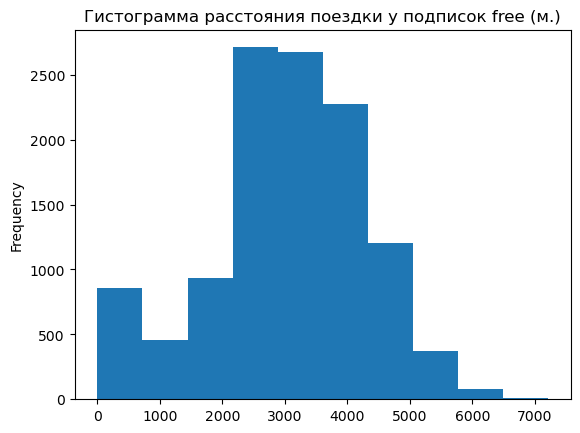

In [83]:
free_sub['distance'].plot(kind='hist', title='Гистограмма расстояния поездки у подписок free (м.)');

По гистограммам видно, что пользователи, которые пользуются ultra подпиской имеют выраженный пик расстояния поездки, в то время как пользователи бесплатной подписки ездят в том же диапозоне, но разброс больше.
<br> Изучу их квартили:

In [29]:
print('Квартили 1 и 3 для ultra: от', round(ultra_sub['distance'].quantile(0.25)), \
     'до', round(ultra_sub['distance'].quantile(0.75)))

print('Квартили 1 и 3 для free: от', round(free_sub['distance'].quantile(0.25)), \
     'до', round(free_sub['distance'].quantile(0.75)))

Квартили 1 и 3 для ultra: от 2785 до 3561
Квартили 1 и 3 для free: от 2367 до 3906


In [30]:
print('Медианная дистанция у подписок ultra больше на', \
      round(ultra_sub['distance'].median() - free_sub['distance'].median()), 'метра')

Медианная дистанция у подписок ultra больше на 34 метра


По этим данным видно, что подписчики ultra ездят в основном в диапозоне от 2,7  до 3,5 километров.
<br>В то время как пользователи без подписки ездят в диапозоне от 2,3 до 3,9 километрах.
<br>
<br>Скорее всего это связано с тем, что пользователся подписки ultra выбирают одни и те же маршруты и ездят на них регулярно (например, от метро до работы или до дома), в то время как пользователи без платной подписки могут ездить по разным маршрутам, от чего разброс у них - выше.

**Длительность поездок в зависимости от типа подписки**

Таким же образом построю гистограмму по столбцу длительности.

<Axes: title={'center': 'Гистограмма длительности поездки у подписок ultra (мин.)'}, ylabel='Frequency'>

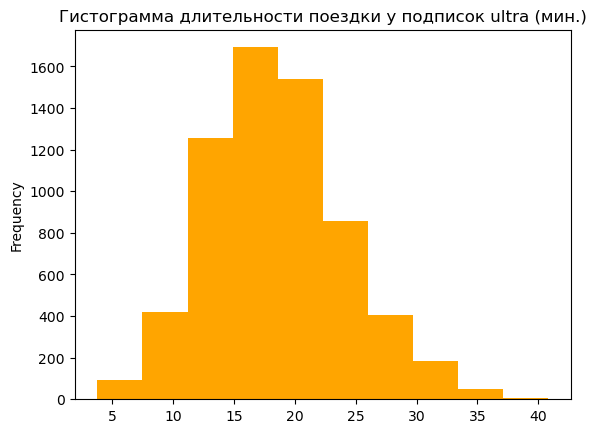

In [31]:
ultra_sub['duration'].plot(kind='hist', color='orange', title='Гистограмма длительности поездки у подписок ultra (мин.)');

<Axes: title={'center': 'Гистограмма длительности поездки у подписок free (мин.)'}, ylabel='Frequency'>

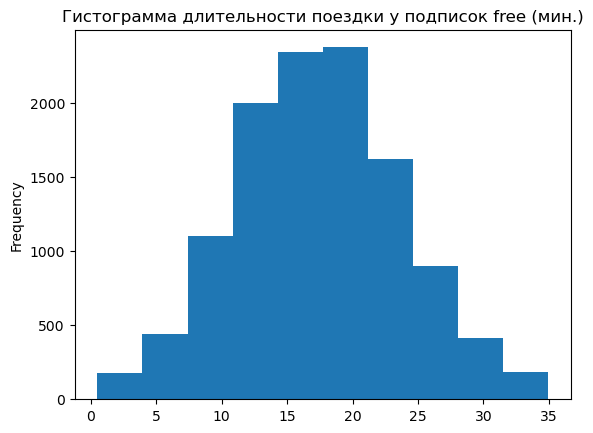

In [32]:
free_sub['duration'].plot(kind='hist', title='Гистограмма длительности поездки у подписок free (мин.)');

In [33]:
print('Квартили 1 и 3 для ultra: от', round(ultra_sub['duration'].quantile(0.25)), \
     'до', round(ultra_sub['duration'].quantile(0.75)))

print('Квартили 1 и 3 для free: от', round(free_sub['duration'].quantile(0.25)), \
     'до', round(free_sub['duration'].quantile(0.75)))

Квартили 1 и 3 для ultra: от 15 до 22
Квартили 1 и 3 для free: от 13 до 22


Здесь наблюдается ровно та же тенденция - у пользователей подписки ultra разброс затрачиваемого времени на поездку меньше, чем у пользователей без платной подписки. 

## Подсчёт выручки

Номера месяцев были добавлены в `full_data`, чтобы рассчитать выручку, которую пользователи сформировали сервису помесячно.
<br>Создам новый датафрейм, в котором помесячно будет указываться информация по пользователям, на основе которой будет рассчитана выручка.

In [34]:
monthly_sales = full_data.groupby(['month','user_id'])\
        .agg({'subscription_type':'first', 'distance':['count', 'sum'], 'duration':'sum'})

#Переименую столбцы
monthly_sales.columns = ['subscription_type', 'drives_amount', 'dist_sum', 'dur_sum']

Длительность поездок приведу к целым числам

In [35]:
monthly_sales['dur_sum'] = np.ceil(monthly_sales['dur_sum'])
monthly_sales['dur_sum'] = monthly_sales['dur_sum'].astype('int64')

Определю функцию, которая рассчитает выручку для каждой строки, основываясь на типе подписки.

In [36]:
def sales(row):
    if row['subscription_type'] == 'ultra':
        sale = 199 + row['dur_sum']*6
        return sale
    if row['subscription_type'] == 'free':
        sale = row['drives_amount']*50 + row['dur_sum']*8
        return sale

Применю функцию к датафрейму и ее результат запишу в новом столбце

In [37]:
monthly_sales['sales'] = monthly_sales.apply(sales, axis=1)

Посмотрим, как теперь выглядит `monthly_sales`

In [38]:
monthly_sales.head()

subscription_type  drives_amount     dist_sum  dur_sum  sales
month user_id                                                              
1     1                   ultra              2  7027.511294       42    451
      3                   ultra              1  3061.777147       13    277
      5                   ultra              1  3914.646990       13    277
      7                   ultra              2  6478.080979       28    367
      12                  ultra              1  3577.151148       33    397

Построю график динамики выручки по месяцам

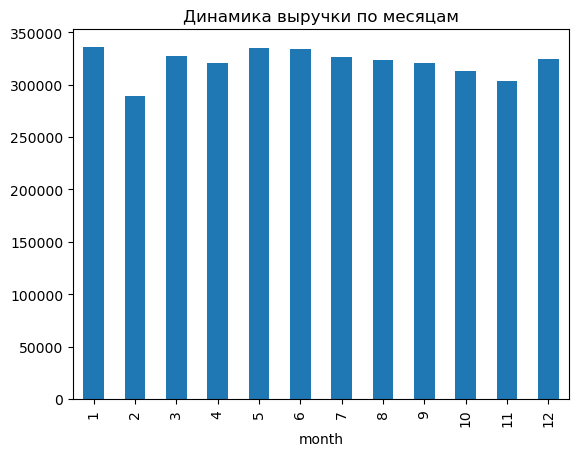

In [39]:
monthly_sales.groupby(level=['month'])['sales'].sum().plot(kind='bar', title='Динамика выручки по месяцам');

## Проверка гипотез

### Проверю гипотезу о том, что пользователи с подпиской тратят больше времени на поездки

_Нулевая гипотеза:_ длительность поездок с подпиской **=** длительности поездок без подписки
<br> _Альтернативная гипотеза:_ длительность поездок с подпиской **>** длительности поездок без подписки

В качестве статистической значимости возьму 5%

In [40]:
#Посколько для этой гипотезы необходимо проверить две выборки - воспользуюсь методом ttest_ind
hyp1 = st.ttest_ind(ultra_sub['duration'], free_sub['duration'], alternative='greater')

print('P-value гипотезы', hyp1.pvalue)

if hyp1.pvalue < 0.05:
    print('Нулевая гипотеза отвергается')
else:
    print('Нулевая гипотеза не может быть отвергнута')

P-value гипотезы 1.2804098316645618e-34
Нулевая гипотеза отвергается


P-value крайне мала. Поэтому гипотеза о равенстве продолжительности поездки отвергается. Есть основания всерьез рассматривать гипотезу о том, что продолжительность поездки с подпиской ultra - выше.

### Проверю гипотезу о том, что расстояние поездки c подпиской не превышает 3130 метров

Поездка в 3130 метров оптимальна с точки зрения износа самоката. Проверю, не превышает ли поездка c подпиской 3130 метров, или нет.

_Нулевая гипотеза:_ Расстояние поездки с подпиской ultra **=** 3130 метрам
<br>_Альтернативная гипотеза:_ Расстояние поездки с подпиской ultra **>** 3130 метров

In [41]:
#Так как это проверка гипотезу по одной выборке - воспользуюсь методом ttest_1samp,
#где за popmean приму оптимальные для износа 3130 метров

hyp2 = st.ttest_1samp(ultra_sub['distance'], popmean=3130, alternative='greater')

print('P-value гипотезы', hyp2.pvalue)

if hyp2.pvalue < 0.05:
    print('Нулевая гипотеза отвергается')
else:
    print('Нулевая гипотеза не может быть отвергнута')

P-value гипотезы 0.9195368847849785
Нулевая гипотеза не может быть отвергнута


Нулевая гипотеза не отвергается. По-видимому, поездки не превышают расстояние износа.
<br>И судя по p-value, расстояние даже меньше, чем 3130 метров. Чтобы убедиться в этом, посмотрим на сколько стандартных отклонений наблюдаемое среднее отклоняется от 3130. 

In [42]:
hyp2.statistic

-1.402123166869486

Она отклоняется влево на 1,4 ст. отклонения. Действительно, судя по имеющимся данным, расстояние поездки достаточно далеко от значения износа

### Проверю гипотезу, выше ли помесячная выручка от пользователей с подпиской, чем выручка пользователей без подписки

Затем проверю гипотезу.

_Нулевая гипотеза:_ помесячная выручка от пользователей с подпиской = помесячной выручке пользователей без подписки
<br>_Альтернативная гипотеза:_ помесячная выручка от пользователей с подпиской > помесячной выручки пользователей без подписки

In [54]:
#Так как эта гипотеза проверяет две выборки - воспользуюсь методом ttest_ind

hyp4 = st.ttest_ind(
                    monthly_sales.query('subscription_type == "ultra"')['sales'],
                    monthly_sales.query('subscription_type == "free"')['sales'],
                    alternative='greater')

print('P-value гипотезы', hyp4.pvalue)

if hyp4.pvalue < 0.05:
    print('Нулевая гипотеза отвергается')
else:
    print('Нулевая гипотеза не может быть отвергнута')

P-value гипотезы 2.8130926188487286e-35
Нулевая гипотеза отвергается


В таком случае есть основания считать, что средний пользователь с подпиской ultra приносит больше выручки, чем пользователь с бесплатной подпиской. Однако, если смотерть помесячную выручку, в среднем она выше у пользователей с бесплатной подпиской. Возможно, это обсуловлено тем, что пользователей с бесплатной подпиской больше в общем объеме.

## Распределения

### Количество промокодов

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соотвествующий платёж.

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей.

Какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%?

Такая ситуация может быть описана биномиальным распределением, ведь есть только удача или неудача (продление подписки или нет).

Задам биномиальное распределение с вероятностью 10% и буду перебирать количество отправленных промокодов.  
Для кадждого распределения буду смотреть, какова вероятность получить 100 и более продлений.  
И когда процент успеха того, что 100 пользователей продлят подписку - будет 95% или больше, верну число отправленных промокодов, с которыми удалось получить такой результат.

In [48]:
for i in range(100, 9999):
    res = st.binom(i, 0.1).cdf(100)
    if 1 - res >= 0.95:
        print('Если отправить', i, 'промокода, то')
        print('вероятость успеха', round(1-res, 2))
        break

Если отправить 1172 промокода, то
вероятость успеха 0.95


### Отправка уведомлений

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40%получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [49]:
#параметры биноминального распределения
n = 1000000
p = 0.4

#Задам параметры нормального распределения равными мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = (n * p * (1 - p))**(1/2)

#задаю аппроксимированное норм распределение
distr = st.norm(mu, sigma)

print('Вероятность того, что уведомление откроют не более 399,5 тыс. пользвателей:', distr.cdf(399500))

Вероятность того, что уведомление откроют не более 399,5 тыс. пользвателей: 0.15371708296369768


## Заключение

Работа состояла из 6 этапов.

1. Загрузка и обзор данных
<br> На этом этапе были изучены имеющиеся данные о пользователях, поездках и условиях подписок:
- Ultima: 6 руб./мин., 199 руб. ежемесячный платеж
- Free: 8 руб./мин., 50 руб. за старт каждой поездки

2. Предобработка данных
<br> На этом этапе были удалены дубликаты и добавлен столбец с обозначением номера месяца.

3. Исследовательский анализ данных
<br> Рассмотрена частота встречаемости городов, доли пользователей по типу подписки, возраст пользователей, преодолеваемое расстояние и продолжительность поездок.

4. Объединение данных
<br> Для дальнейшего анализа все данные были объединены в один датафрейм и разделены по типу подписки.

5. Подсчет выручки
<br> Помесячно была подсчитана выручка, которую принес каждый пользователь.

6. Проверка гипотез
<br> Были проверены гипотезы о пользователях с подпиской: тратят больше времени на поездки, не превышают 3130 метров, приносят больше выручки.
****

**Ключевые выводы по данным**

**1. Описание потребителей и пользования сервисом**
<br> Примерно одинаковое количество пользователей (по 200 чел.) представлены во всех 6 городах: Екатеринбург, Краснодар, Москва, Омск, Пятигорск, Ростов-на-Дону, Сочи, Тюмень.
<br>**54%** пользователей пользуются бесплатной подпиской, **46%** пользуются подпиской ultra.
<br>Возраст потребителей услуг во всех городах одинаковый - преимущественно **от 22 до 28 лет**.
<br>Половина поездок имеет **расстояние от 2500 до 3700 м.** и **временную продолжительность от 13 до 21 минуты.** Данные не меняются даже с течением месяцев или в зависимости от города.


**2. Поездки в зависимости от подписки**
<br> Пользователи с платной подпиской медианно ездят на 34 м. дальше пользователей бесплатной версии.
<br> Подписчики ultra ездят в основном в диапозоне от **2,7**  до **3,5** километров.
<br> Пользователи без подписки ездят в диапозоне от **2,3** до **3,9** километрах.
<br> Должно быть, меньший разброс у платных подписчиков обусловлен тем, что они ездят регулярно по одинаковым маршрутам.
<br> 50% поездок подписчиков ultra укладывается в 15-22 минут, тогда как у пользователей беспл. верс. в 13-22 мин. 

**3. Динамика выручки**
<br> Пользователи приносят каждый месяц стабильно около 330 тыс. руб.

**4. Гипотезы**
<br> Вероятно, что пользователи с платной подпиской тратят **больше** времени на поездки.
<br> Пользователи с подпиской в среднем **не** ездят дальше 3130 метров и не изнашивают самокаты.
<br> Помесяная выручка пользователей с подпиской в среднем **меньше** выручки пользователей без подписки, однако средний пользователь с подпиской ultra приносит больше выручки, чем пользователь без платной подписки.

**5. Промокоды и уведомления**  
Чтобы подписку продлило минимум 100 человек с вероятностью успеха в 95%, нужно отправить 1172 промокода.  
Если отправить миллиону пользователей уведомления, шанс, что их откроет не более 399,5 тыс. пользователей, составляет 15%.